In [176]:
import jax
import jax.numpy as jnp
from jax import jit, random
import numpy as np
import optax

BATCH_SIZE = 100
LEARNING_RATE = 1e-3
LAYER_SIZES = [1, 20, 20, 20, 20, 20, 20, 20, 20, 1]
NUM_EPOCHS = 4_000
OPTIMIZER = optax.adam(learning_rate=LEARNING_RATE)
#OPTIMIZER = optax.yogi(learning_rate=LEARNING_RATE)
#OPTIMIZER = optax.adabelief(learning_rate=LEARNING_RATE)
#OPTIMIZER = optax.fromage
#OPTIMIZER = optax.optimistic_gradient_descent(learning_rate=LEARNING_RATE)
ACTIVATION = jnp.tanh
#ACTIVATION = jax.nn.relu
#ACTIVATION = jax.nn.sigmoid
#ACTIVATION = jax.nn.silu
#ACTIVATION = jax.nn.softplus
#ACTIVATION = jax.nn.softmax

L = 1.0
N = 4 # Quantum Number
t = jnp.linspace(start=0, stop=L, num=1000)

- See [Activation Functions](https://jax.readthedocs.io/en/latest/jax.nn.html?highlight=sigmoid) for a list of possible activations.
- See [Optimizers](https://optax.readthedocs.io/en/latest/api.html#optax.yogi) for a list of optimizers.

In [177]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
  w_key, b_key = random.split(key)
  return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,1))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
  """
  returns:
  <list> of length: (#layers - 1)

  Each list item contains a <tuple> of len(): 2 (Weights and Biases)

  Each tuple consists of 2 Arrays of dimension: 

  """
  
  keys = random.split(key, len(sizes))
  return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

initial_params = init_network_params(LAYER_SIZES, random.PRNGKey(0))

In [178]:
def net(params, x):
    activations = x
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = ACTIVATION(outputs)

    final_w, final_b = params[-1]
    output = jnp.dot(final_w, activations) + final_b
    return output.reshape()

# check
net(initial_params, 2.0)

Array(-0.0107695, dtype=float32)

We want to train the neural network for the Schrödinger equation of a particle in a 1-D box:

$$
\hat{H} \psi(x) = E\psi(x)
$$

Under certain assumptions this becomes a 2nd order homogeneous linear differential equation:

$$
\ddot \psi(x) + \frac{2mE}{\hbar^2} \psi(x) = 0,
$$

The boundary conditions are given as:

$$
\psi(0) = \psi(L) = 0
$$


Therefore we define an objective 

$$
\mathcal{L}(\mathbf{W}) = \frac{1}{M}\sum_{i=1}^M (\ddot \psi_\mathbf{W} + \frac{2mE}{\hbar^2} \psi_\mathbf{W}) ^ 2 + (\psi_\mathbf{W}(0) - \psi_0) ^ 2 + (\psi_\mathbf{W}(L) - \psi_L) ^ 2
$$

In [179]:
a = (N ** 2) * (np.pi ** 2)
y0_0 = 0.
y0_L = 0.
y0_p = np.pi * 2
yL_p = np.pi * 2

#@jit
def ode(params, t):
    nn = lambda t: net(params, t)
    dnn = jax.grad(nn)
    ddnn = jax.grad(dnn)
    return ddnn(t) + a * nn(t)

# check
ode(initial_params, 0.)

Array(-15.305861, dtype=float32)

In [180]:
ode_batched = jax.vmap(ode, in_axes=[None, 0])
net_batched = jax.vmap(net, in_axes=[None, 0])
dnn = jax.grad(net, argnums=1)

#@jit
def loss(params: optax.Params, batch: jnp.ndarray) -> jnp.ndarray:
    y_hat = ode_batched(params, batch)
    ode_loss = jnp.mean(y_hat ** 2)

    init_loss_1 = (net(params, 0.) - y0_0) ** 2
    init_loss_2 = (net(params, L) - y0_L) ** 2
    #init_loss_3 = (jax.grad(net, argnums=1)(params, 0.) - y0_p) ** 2
    #init_loss_4 = (jax.grad(net, argnums=1)(params, L) - yL_p) ** 2
    #init_loss_5 = 1/net(params, 0.25)
    init_loss_6 = 1/(jax.grad(net, argnums=1))(params, 0.)

    return ode_loss + init_loss_1 + init_loss_2 + init_loss_6

# check
loss(initial_params, jnp.array([1., 2.]))

Array(-7.968516e+12, dtype=float32)

In [181]:
key = jax.random.PRNGKey(42)

def fit(params: optax.Params, optimizer: optax.GradientTransformation, key) -> optax.Params:
  opt_state = optimizer.init(params)

  @jit
  def step(params, opt_state, batch):
    loss_value, grads = jax.value_and_grad(loss)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  for epoch in range(NUM_EPOCHS):
      shuffle_key, key = jax.random.split(key)
      batches = jax.random.permutation(shuffle_key, t)
      batches = batches.reshape(BATCH_SIZE, -1)
      for batch in batches:
          params, opt_state, loss_value = step(params, opt_state, batch)
      if epoch % 100 == 0:
          print(f'epoch {epoch}, loss: {loss_value}')

  return params

train_key, key = jax.random.split(key)
params = fit(initial_params, OPTIMIZER, key)


epoch 0, loss: 3462306048.0
epoch 100, loss: 2028031.75
epoch 200, loss: 26734.3359375
epoch 300, loss: 389.3465881347656
epoch 400, loss: 88.24552917480469
epoch 500, loss: 3.634086847305298
epoch 600, loss: 3.339033603668213
epoch 700, loss: 7.154194355010986
epoch 800, loss: 6.616751670837402
epoch 900, loss: 3.70101261138916
epoch 1000, loss: 6.572519302368164
epoch 1100, loss: 4.010317325592041
epoch 1200, loss: 3.6741268634796143
epoch 1300, loss: 2.8352890014648438
epoch 1400, loss: 4.095478057861328
epoch 1500, loss: 2.610335350036621
epoch 1600, loss: 4.275180339813232
epoch 1700, loss: 5.103789329528809
epoch 1800, loss: 4.278599739074707
epoch 1900, loss: 5.014890670776367
epoch 2000, loss: 3.0493717193603516
epoch 2100, loss: 3.238281726837158
epoch 2200, loss: 3.969200372695923
epoch 2300, loss: 2.9397568702697754
epoch 2400, loss: 4.5259904861450195
epoch 2500, loss: 3.6803629398345947
epoch 2600, loss: 2.6539080142974854
epoch 2700, loss: 3.9797582626342773
epoch 2800, l

In [182]:
def sol(t):
    return np.sqrt(2/L) * np.sin(N * np.pi * t/L)

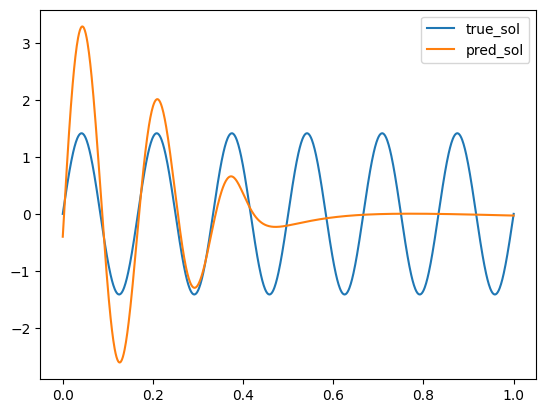

In [183]:
import matplotlib.pyplot as plt

model = jax.vmap(lambda t: net(params, t))
model_2 = model(t) ** 2
integral = np.trapz(model_2, t)

plt.plot(t, sol(t), label='true_sol')
plt.plot(t, model(t)*1/np.sqrt(integral), label='pred_sol')
plt.legend()